## INTRODUCTION

Sentiment analysis is a natural language processing (NLP) technique used to determine the sentiment of textual data (Positive, Negative, or Neutral). It is used to assess brand popularity, customer feedback, customer needs, marketing campaign success rates, and competitor brand monitoring, among other things.

The study aims to assess brand engagement in terms of the number of tweets, likes, retweets, and sentiment of tweets with the following tags: @jumia online OR @jumiaNigeria OR @jumiatravelNG OR #jumiaNigeria OR #jumia.


## RESEARCH QUESTIONS:

1. Who are the users with the highest number of tweets

2. Which location has the the highest number of tweets

3. Which source has the highest number of tweets

4. Which tweets have the highest number of likes and retweets

5. What is the overall sentiment of all the tweets

6. What is the sentiment of the tweet with the highest likes and retweet

# IMPORT LIBRARIES

In [2]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI
from emot.emo_unicode import EMOTICONS_EMO 

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer() 

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DATA SOURCE
The data is scraped from twitter.com using the following tags: #jumiaNigeria, #jumia @jumia_online, @jumiaNigeria, @jumiatravelNG 


In [ ]:
query = "(@jumia_online OR @jumiaNigeria OR @jumiatravelNG OR #jumiaNigeria OR #jumia) since:2020-01-01 until:2023-01-30"

tweets = []
for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i>20000:
        break
    else:
        tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])
df = pd.DataFrame(tweets, columns = ['date', 'ID', 'url', 'username', 'source', 'location', 'tweet', 'num_of_likes', 'num_of_retweets'])
df.to_csv('jumia2.csv', mode = 'a')

C:\Users\DELL\AppData\Local\Temp\ipykernel_4100\2895114154.py:10: FutureWarning: content is deprecated, use rawContent instead
  tweets.append([tweet.date, tweet.id, tweet.url, tweet.user.username, tweet.sourceLabel, tweet.user.location, tweet.content, tweet.likeCount, tweet.retweetCount])


In [50]:
# df = pd.read_csv('jumia2.csv')
tdf = df.copy()
tdf.shape

(20001, 9)

# PREPROCESSING
Cleaning the tweets

In [51]:
def format_tweets(text): 
    text = text.lower()
    text = ' '.join(re.sub("[^0-9A-Za-z]",' ', text).split())    
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

formatted_tweet = tdf['tweet'].apply(format_tweets)
tdf.insert(7, 'formatted_tweet',formatted_tweet)

In [176]:
def format_location(text): 
    text = text.lower()
    text = ' '.join(re.sub("[^0-9A-Za-z]",' ', text).split())   
    return text

tdf['formatted_location'] = tdf['location'].apply(format_location)

In [192]:
tdf.head(4)


,date,time,week_day,week,year_month,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets,Polarity,Sentiment,location_modified,location_modified2,location_modified3,formatted_location,location_modified4,location_modified5
0,2023-01-29 22:42:47+00:00,22:42:47,Sunday,4,2023-01,ChukwuedoMark,Twitter for Android,,@JumiaNigeria please a friend ordered a packag...,jumianigeria please friend ordered package 2we...,0,0,0.35,Positive,False,False,Ireland,,None,norway
1,2023-01-29 21:45:03+00:00,21:45:03,Sunday,4,2023-01,AdebiyiJoshua03,Twitter for iPhone,,@JumiaNigeria @Jumia_Group \nIs it until i dra...,jumianigeria jumia group drag guys refund mone...,0,0,-0.05,Negative,False,False,Ireland,,None,norway
2,2023-01-29 20:26:24+00:00,20:26:24,Sunday,4,2023-01,jimchizzy,Twitter Web App,"NAIROBI, KENYA",#JUMIANIGERIA #Nigeria #NigeriaDecides2023 #Ni...,jumianigeria nigeria nigeriadecides2023 nigeri...,0,0,0.10,Positive,False,False,Ireland,nairobi kenya,None,norway
3,2023-01-29 13:43:02+00:00,13:43:02,Sunday,4,2023-01,Sordeeque50,Twitter for Android,,@JumiaNigeria @JumiaNGHelp I bought two 500 ae...,jumianigeria jumianghelp bought two 500 aed wo...,0,0,-0.18,Negative,False,False,Ireland,,None,norway


# WRANGLING
Extracting week, month and year from date

In [54]:
time = pd.to_datetime(tdf['date']).dt.strftime("%H:%M:%S") 
tdf.insert(1, 'time',time)
week_day = pd.to_datetime(tdf['date']).dt.strftime("%A")
tdf.insert(2, 'week_day',week_day)
week = pd.to_datetime(tdf['date']).dt.isocalendar().week.astype(int)
tdf.insert(3, 'week',week)
year_month = pd.to_datetime(tdf['date']).dt.strftime('%Y-%m')
tdf.insert(4, 'year_month',year_month)

tdf.head(2)

,date,time,week_day,week,year_month,ID,url,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets
0,2023-01-29 22:42:47+00:00,22:42:47,Sunday,4,2023-01,1619828429280641024,https://twitter.com/ChukwuedoMark/status/16198...,ChukwuedoMark,Twitter for Android,,@JumiaNigeria please a friend ordered a packag...,jumianigeria please friend ordered package 2we...,0,0
1,2023-01-29 21:45:03+00:00,21:45:03,Sunday,4,2023-01,1619813900547166210,https://twitter.com/AdebiyiJoshua03/status/161...,AdebiyiJoshua03,Twitter for iPhone,,@JumiaNigeria @Jumia_Group \nIs it until i dra...,jumianigeria jumia group drag guys refund mone...,0,0


In [56]:
tdf.drop(['ID','url'],axis=1, inplace=True)

,date,time,week_day,week,year_month,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets
0,2023-01-29 22:42:47+00:00,22:42:47,Sunday,4,2023-01,ChukwuedoMark,Twitter for Android,,@JumiaNigeria please a friend ordered a packag...,jumianigeria please friend ordered package 2we...,0,0
1,2023-01-29 21:45:03+00:00,21:45:03,Sunday,4,2023-01,AdebiyiJoshua03,Twitter for iPhone,,@JumiaNigeria @Jumia_Group \nIs it until i dra...,jumianigeria jumia group drag guys refund mone...,0,0
2,2023-01-29 20:26:24+00:00,20:26:24,Sunday,4,2023-01,jimchizzy,Twitter Web App,"NAIROBI, KENYA",#JUMIANIGERIA #Nigeria #NigeriaDecides2023 #Ni...,jumianigeria nigeria nigeriadecides2023 nigeri...,0,0
3,2023-01-29 13:43:02+00:00,13:43:02,Sunday,4,2023-01,Sordeeque50,Twitter for Android,,@JumiaNigeria @JumiaNGHelp I bought two 500 ae...,jumianigeria jumianghelp bought two 500 aed wo...,0,0
4,2023-01-29 12:42:16+00:00,12:42:16,Sunday,4,2023-01,jumbokendra33,Twitter for iPhone,🇬🇧,@JumiaNigeria @JumiaNigeria pls refund my money.,jumianigeria jumianigeria pls refund money,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19996,2022-04-19 11:37:52+00:00,11:37:52,Tuesday,16,2022-04,QAwolalu,Twitter for Android,Nigeria,@JumiaNigeria \n Order number 1858364242. For ...,jumianigeria order number 1858364242 3 weeks c...,1,0
19997,2022-04-19 11:22:49+00:00,11:22:49,Tuesday,16,2022-04,sknnymusic,Twitter for iPhone,"Port Harcourt, Nigeria",@JumiaNigeria send my money back abeg una dey ...,jumianigeria send money back abeg una dey use ...,0,0
19998,2022-04-19 11:19:37+00:00,11:19:37,Tuesday,16,2022-04,bros_tobi,Twitter for Android,,@JumiaNGHelp @JumiaNigeria u haven't refunded ...,jumianghelp jumianigeria u refunded since 25th...,0,0
19999,2022-04-19 11:16:56+00:00,11:16:56,Tuesday,16,2022-04,sknnymusic,Twitter for iPhone,"Port Harcourt, Nigeria",@JumiaNigeria give me my money back wtf,jumianigeria give money back wtf,0,0


# EXPLORATORY DATA ANALYSIS


## 1. Who are the users with the highest number of tweets

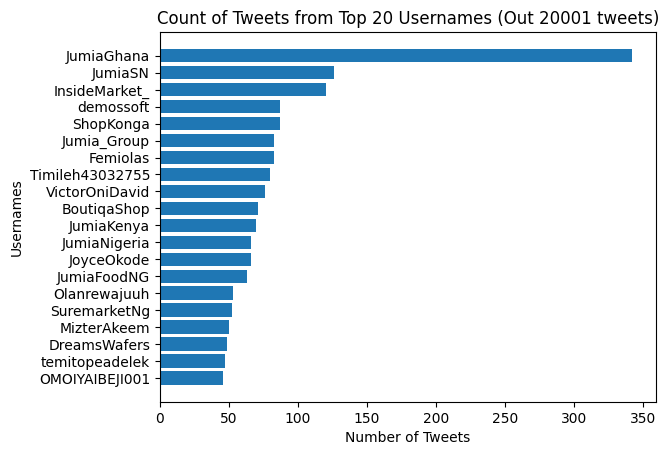

In [57]:
count_of_tweets_dict = tdf['username'].value_counts().head(20).to_dict()

def top_20_usernames(dict):
    usernames = []
    for key,value in count_of_tweets_dict.items():
        usernames.append(key)
    return usernames
                            

def no_of_tweets_username(dict):
    no_of_tweets = []
    for key,value in count_of_tweets_dict.items():
        no_of_tweets.append(value)
    return no_of_tweets

usernames = top_20_usernames(count_of_tweets_dict)
no_of_tweets = no_of_tweets_username(count_of_tweets_dict)
total_tweets = tdf['tweet'].shape[0]


plt.barh(usernames, no_of_tweets)
# plt.xlabel('usernames')
plt.xlabel('Number of Tweets')
plt.ylabel('Usernames')
plt.title(f'Count of Tweets from Top 20 Usernames (Out {total_tweets} tweets)')

plt.gca().invert_yaxis()

In [248]:
tdf['username'].nunique()


9247

## 2. Which location has the the highest number of tweets

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 127969 (\N{HOUSE WITH GARDEN}) missing from current font.
  func(*args, **kwargs)
C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127969 (\N{HOUSE WITH GARDEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


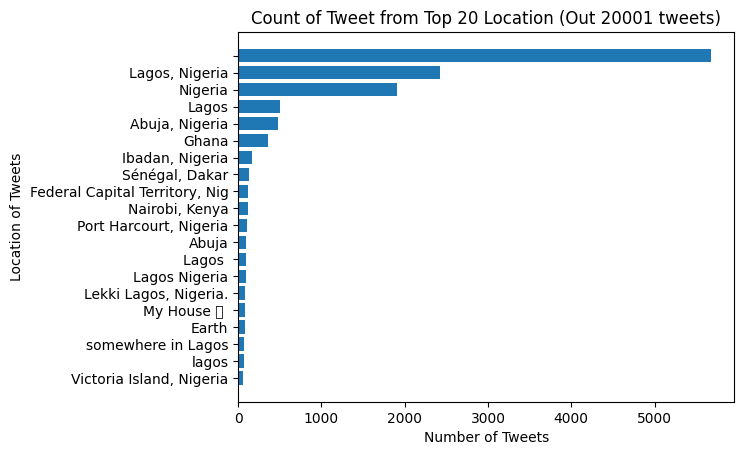

In [58]:
location_of_tweets_dict = tdf['location'].value_counts().head(20).to_dict()

def top_20_location(dict):
    location = []
    for key,value in location_of_tweets_dict.items():
        location.append(key)
    return location
                            

def no_of_tweets_location(dict):
    no_of_tweets_location = []
    for key,value in location_of_tweets_dict.items():
        no_of_tweets_location.append(value)
    return no_of_tweets_location

location_of_tweets = top_20_location(location_of_tweets_dict)
no_of_tweets_location = no_of_tweets_location(location_of_tweets_dict)
total_tweets = tdf['tweet'].shape[0]



plt.barh(location_of_tweets, no_of_tweets_location)
# plt.xlabel('usernames')
plt.xlabel('Location of Tweets')
plt.ylabel('Number of Tweets')
plt.title(f'Count of Tweet from Top 20 Location (Out {total_tweets} tweets)')

plt.gca().invert_yaxis()

In [215]:
top_location = pd.DataFrame({"location": location_of_tweets, "num_of_tweets": no_of_tweets_location})
top_location = top_location.drop(0)
top_location.to_csv('top_locations.csv', mode = 'a')

## 3. Which source has the highest number of tweets

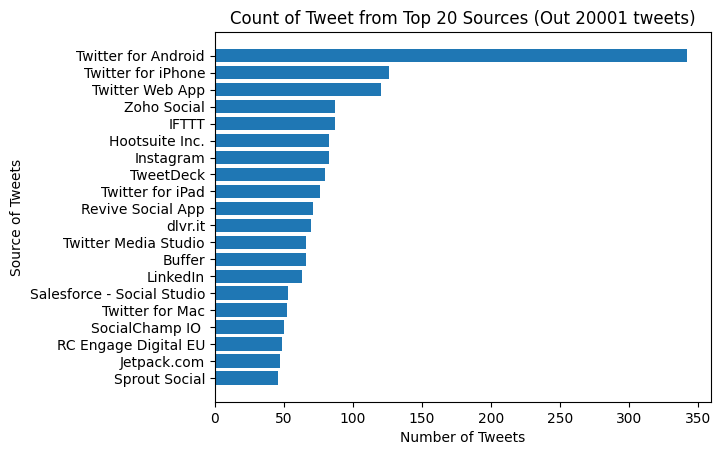

In [59]:
source_of_tweets_dict = tdf['source'].value_counts().head(20).to_dict()

def top_20_sources(dict):
    sources = []
    for key,value in source_of_tweets_dict.items():
        sources.append(key)
    return sources
                            

def no_of_tweets_sources(dict):
    no_of_tweets_sources = []
    for key,value in source_of_tweets_dict.items():
        no_of_tweets_sources.append(value)
    return no_of_tweets

source_of_tweets = top_20_sources(source_of_tweets_dict)
no_of_tweets = no_of_tweets_sources(source_of_tweets_dict)
total_tweets = tdf['tweet'].shape[0]



plt.barh(source_of_tweets, no_of_tweets)
plt.xlabel('Number of Tweets')
plt.ylabel('Source of Tweets')
plt.title(f'Count of Tweet from Top 20 Sources (Out {total_tweets} tweets)')

plt.gca().invert_yaxis()

## 4. Which tweets have the highest number of likes and retweets

In [67]:
tdf_likes =  tdf[['username','num_of_likes']]
tdf_likes.sort_values('num_of_likes', ascending=False).head(10)

,username,num_of_likes
15702,Jumia_Group,1162
3136,TokunboAdesina,598
490,SatoshiBTCss,389
12347,Pi_Observatory,349
13813,Jumia_Group,297
10347,Abeebullah_a,272
9196,PulseNigeria247,268
14632,Jumia_Group,235
8120,TheRealGoody_,229
14528,doyinokupe,219


In [66]:
tdf_num_of_retweet = tdf[['username','num_of_retweets']]
tdf_num_of_retweet.sort_values('num_of_retweets', ascending=False).head(10)

,username,num_of_retweets
10347,Abeebullah_a,261
3136,TokunboAdesina,241
8120,TheRealGoody_,209
8187,johnmik1_,193
669,Sysrqgit,177
727,Sysrqgit,165
329,Sysrqgit,162
182,Sysrqgit,159
1391,Sysrqgit,156
145,Sysrqgit,152


## SENTIMENT ANALYSIS

## 5. What is the overall sentiment of all the tweets

In [68]:
# Function for polarity score
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

# Function to get sentiment type
def sentimenttextblob(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive" 

In [69]:
# using the functions to get the polarity and sentiment
tdf['Polarity'] = tdf['formatted_tweet'].apply(polarity)
tdf['Sentiment'] = tdf['Polarity'].apply(sentimenttextblob)
jumia_sentiments = tdf['Sentiment'].value_counts()
jumia_sentiments.to_frame('num_of_tweets')

,num_of_tweets
Neutral,9771
Positive,5997
Negative,4233


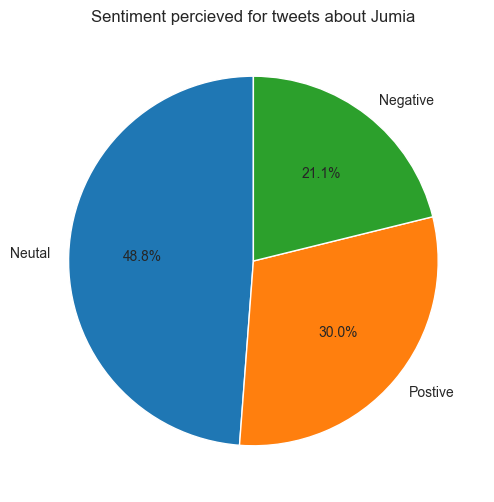

In [258]:
labels = ['Neutal','Postive','Negative']
values = jumia_sentiments.to_frame('num_of_tweets')['num_of_tweets']

sns.set_style('darkgrid')
plt.figure(figsize=(6,6))
plt.pie(unilever_sentiments, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment percieved for tweets about Jumia')

plt.show()

In [ ]:
tdf.to_csv('jumia_modified.csv', mode = 'a')

### Analysis on some tweets that have a negative sentiment

In [83]:
tdf.query(''' Sentiment == 'Negative' ''').sort_values('Polarity', ascending=True).head(3)

                                                      

,date,time,week_day,week,year_month,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets,Polarity,Sentiment
18852,2022-04-30 13:20:07+00:00,13:20:07,Saturday,17,2022-04,BoboOnyekachi,Twitter for Android,,@JumiaNigeria Jumia is making life miserable f...,jumianigeria jumia making life miserable vendo...,2,0,-1.0,Negative
14964,2022-06-13 07:20:35+00:00,07:20:35,Monday,24,2022-06,Chinaza_Faith_,Twitter for Android,"Lagos, Nigeria",@JumiaNigeria Jumia is the worst e-commerce si...,jumianigeria jumia worst e commerce site sell ...,0,0,-1.0,Negative
15038,2022-06-11 22:43:27+00:00,22:43:27,Saturday,23,2022-06,arizon2k9,Twitter for Android,,@VictorOniDavid @JumiaNigeria @Jumia_Group @Ju...,victoronidavid jumianigeria jumia group jumiak...,0,0,-1.0,Negative


In [84]:
print(tdf['tweet'][18852])
print(tdf['tweet'][14964])
print(tdf['tweet'][15038])

@JumiaNigeria Jumia is making life miserable for vendors, how can  you be 45% from each item being shippe? Fashion 18% and u want vendors to reduce their prices?
@JumiaNigeria Jumia is the worst e-commerce site to sell on. If you value your sanity as a vendor, you should by all means avoid them. They are worst than the devil himself. They charge 20% of whatever is sold plus an additional contribution for shipping, despite the fact that they already
@VictorOniDavid @JumiaNigeria @Jumia_Group @JumiaKenya @JUMIAEgypt @JumiaMaroc @jumiatravelNG @JumiaGhana @JumiaUG The worst ever... Every year Jumia comes with a strategy to liquidate it's vendors. 

2019... Shipping fee for just a wedding ring that's not up to 0.5kg was #100

2020.... They increased the shipping fee to #430
2021...


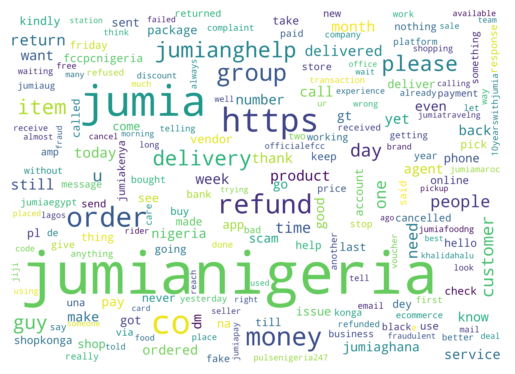

In [70]:
list_of_tweets = tdf['formatted_tweet'].tolist()
list_of_tweets = " ".join(list_of_tweets)
w_cloud = WordCloud(collocations = False,max_words=200, background_color = 'white', width = 7000, height = 5000).generate(list_of_tweets)

plt.imshow(w_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 6. What is the sentiment of the tweet with the highest likes and retweets

In [75]:
tdf.query(''' username == 'TokunboAdesina' ''' )

,date,time,week_day,week,year_month,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets,Polarity,Sentiment
3064,2022-12-04 03:22:57+00:00,03:22:57,Sunday,48,2022-12,TokunboAdesina,Twitter for Android,,#Jumia is closing its office in Dubai and movi...,jumia closing office dubai moving top team afr...,50,8,0.5,Positive
3136,2022-12-03 00:29:59+00:00,00:29:59,Saturday,48,2022-12,TokunboAdesina,Twitter for Android,,#Jumia posted an accumulated loss of $1.5 bill...,jumia posted accumulated loss 1 5 billion thir...,598,241,0.0,Neutral
5418,2022-11-07 21:22:55+00:00,21:22:55,Monday,45,2022-11,TokunboAdesina,Twitter for Android,,The co-founders of #Jumia have stepped down as...,co founders jumia stepped leaders e commerce c...,11,0,0.0,Neutral


In [213]:
TokunboAdesina_tweets = tdf['tweet']
print(TokunboAdesina_tweets.loc[3073])
print(TokunboAdesina_tweets.loc[3145])
print(TokunboAdesina_tweets.loc[5430])

#Jumia is closing its office in Dubai and moving its top team to Africa to reduce operational cost.
#Jumia posted an accumulated loss of $1.5 billion as of the third quarter.         😢
The co-founders of #Jumia have stepped down as leaders of the e-commerce company


In [ ]:
tdf.query(''' username == 'SatoshiBTCss' ''' )

In [110]:
tdf['tweet'][487]


'Advantages of #DBMETA #ecommerce: \n1. #Shop and #earn: Get #complimentary $DBM while shopping.\n2. #Purchases enjoy a minimum #commission of 23% of the total consumption volume of all your downlines.\n3. Soon to partner with #Jumia, #Amazon, #eBay, #Shopee!\n\nhttps://t.co/fVyX2cUUol https://t.co/T3MZhSvQak'

In [250]:
tdf.query(''' username == 'Abeebullah_a' ''' )

,date,time,week_day,week,year_month,ID,url,username,source,location,tweet,formatted_tweet,num_of_likes,num_of_retweets
10076,2022-08-21 09:22:47+00:00,09:22:47,Sunday,33,2022-08,1561282657677344768,https://twitter.com/Abeebullah_a/status/156128...,Abeebullah_a,Twitter for Android,,@Hamzah_X10 @timmynaija @JumiaNigeria @ShopKon...,hamzah x10 timmynaija jumianigeria shopkonga t...,0,0
10080,2022-08-21 08:49:34+00:00,08:49:34,Sunday,33,2022-08,1561274298312056832,https://twitter.com/Abeebullah_a/status/156127...,Abeebullah_a,Twitter for Android,,@micky_j240 @timmynaija @JumiaNigeria @ShopKon...,micky j240 timmynaija jumianigeria shopkonga t...,0,0
10312,2022-08-18 07:05:06+00:00,07:05:06,Thursday,33,2022-08,1560160844687843328,https://twitter.com/Abeebullah_a/status/156016...,Abeebullah_a,Twitter for Android,,@timmynaija @JumiaNigeria @ShopKonga it will b...,timmynaija jumianigeria shopkonga hard extreme...,0,0
10319,2022-08-18 05:14:11+00:00,05:14:11,Thursday,33,2022-08,1560132933742170112,https://twitter.com/Abeebullah_a/status/156013...,Abeebullah_a,Twitter for Android,,@TadyJerry @timmynaija @JumiaNigeria @ShopKong...,tadyjerry timmynaija jumianigeria shopkonga bo...,0,0
10320,2022-08-18 05:13:54+00:00,05:13:54,Thursday,33,2022-08,1560132861184905216,https://twitter.com/Abeebullah_a/status/156013...,Abeebullah_a,Twitter for Android,,@jeighsmallz @timmynaija @JumiaNigeria @ShopKo...,jeighsmallz timmynaija jumianigeria shopkonga ...,0,0
10347,2022-08-17 17:52:08+00:00,17:52:08,Wednesday,33,2022-08,1559961286624034818,https://twitter.com/Abeebullah_a/status/155996...,Abeebullah_a,Twitter for Android,,@timmynaija @JumiaNigeria @ShopKonga God bless...,timmynaija jumianigeria shopkonga god bless si...,272,261


In [112]:
tdf['tweet'][10350]

"@timmynaija @JumiaNigeria @ShopKonga God bless you more sir, I'd really appreciate this sir.\n\nI'm grateful 🙏🙏 https://t.co/eNosdjlexL"

In [ ]:
tdf.query(''' username == 'TheRealGoody_' ''' )

In [114]:
tdf['tweet'][8127]

'Enjoy amazing discounts when you shop on @JumiaNigeria. Just use my voucher code 🔥KBF-GOODY🔥to get 10% discount on all jumia orders\n\nASUU Nia long Wike Ime Udoka Shakira Crypto Cuppy Idris Elba Tom Hardy Blacko Naomi Shakira #MaguireOut More Love Less Ego'

## FINDINGS

The total number of tweets retrieved are 20001 from 9247 users. JumiaGhana had the highest number of tweets (340). Tweets came from different parts of world but majority (over 5,000) were from Nigeria. Majority of the tweets (over 11,000) were from an android device.

Tweets from Jumia_Group (1,162 ) and TokunboAdeshina (598)  had the highest number of likes. Tweets from Abeebullah_a (261) and TokunboAdeshina (241) had the highest number of retweets.

Majority of the tweets 9,771 (49%) had a neutral sentiment, 5,997 (30%) had a positive sentiment and 4233 (49%) had a negative. 
Majority (3700) of the tweets were posted on a Tuesday, and users are most active between the hours 8am and 3pm. Majority (1498) of tweets were posted around 10am. 


![SA_Dashboard(Jumia)](SA_Dashboard(Jumia).png)